# Getting started with using LF Energy for load flow simulations
Before first go, these commands should be run to make sure the environment is set

In [100]:
pip install uv

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


I am using uv to handle dependecies etc. so commands are based on this.


In [48]:
#importing the libraries
import pypowsybl as pp
import pypowsybl.loadflow as lf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os #to save files to path
from pypowsybl._pypowsybl import VoltageInitMode, BalanceType
SAVE_DIR = "Saved_results"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
# code to create the network
def create_9_bus_network():
    n = pp.network.create_ieee9() #creating the network based on built in network template
    buses=n.get_buses()
    print(buses)
    
    generators=n.get_generators()
    print(generators)
    
    lines=n.get_lines()
    print(lines)
    
    transformers=n.get_2_windings_transformers()
    print(transformers)
    
    loads=n.get_loads()
    print(loads)
    return n

In [ ]:
#Standard way to simulate
# here we just use the built in default values for IEEE 9bus system and run an ordinary powerflow simulation....
n_base=create_9_bus_network()
results=pp.loadflow.run_ac(n_base)



      name  v_mag  v_angle  connected_component  synchronous_component  \
id                                                                       
VL1_0       104.0   0.0000                    0                      0   
VL1_1       102.5  -2.2160                    0                      0   
VL2_0       102.5   9.2800                    0                      0   
VL2_1       102.5   3.7197                    0                      0   
VL3_0       102.5   4.6647                    0                      0   
VL3_1       103.2   1.9667                    0                      0   
VL5_0        99.5  -3.9880                    0                      0   
VL6_0       101.2  -3.6870                    0                      0   
VL8_0       101.5   0.7275                    0                      0   

      voltage_level_id  
id                      
VL1_0              VL1  
VL1_1              VL1  
VL2_0              VL2  
VL2_1              VL2  
VL3_0              VL3  
VL3_1     

## Plotting results

### Topology


In [ ]:
#We can plot the results in SLDs, where the arrows indicate direction and active(black) / reactive (blue) power flow. 
# SLDs can be printed for one voltage level (specified by 'VL1','VL2', 'VL3', 'VL5', 'VL6' or 'VL8' ). If SLD for non existing voltage level is tried this returs error ('VL4', 'VL7' or 'VL9')
n_base.get_single_line_diagram('VL1')

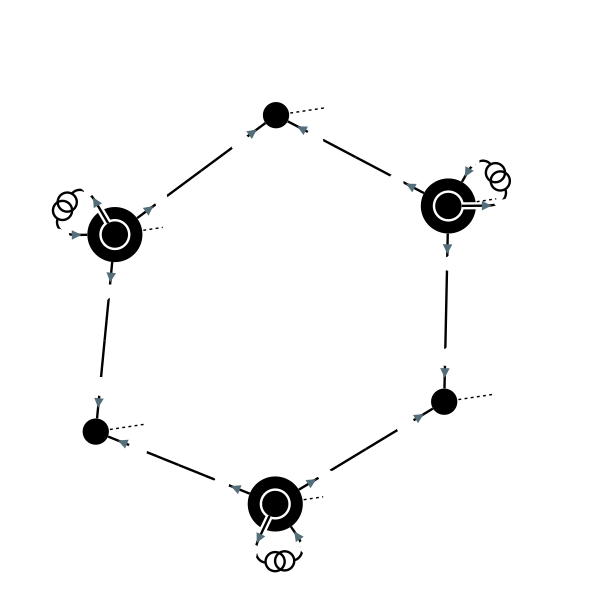

In [ ]:
# You can also get the entire network plotted with get_network_area_diagram(). Here the voltage level can be specified, an this returs similar plot, but only for the specified voltage level. 
n_base.get_network_area_diagram()

In [ ]:
# The plot can be saved to file as svg. 

path=os.path.join(SAVE_DIR,'ieee9_sld.svg') # using a specified folder to store the plots...
n_base.write_single_line_diagram_svg('VL1',path)

### Customizing the variables

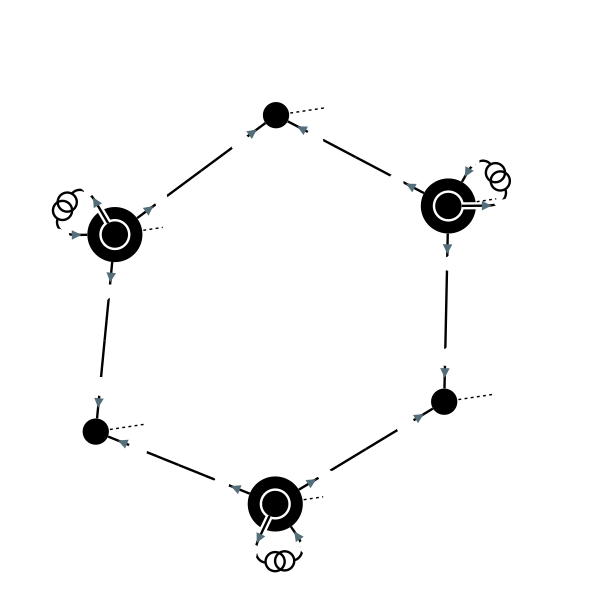

In [ ]:
# We now compare the network results to eachother when changing some parameters...
# Load the standard IEEE 9-bus network

n2 = pp.network.create_ieee9() # we can call it n2 now, and keep the default as n_base
results1=pp.loadflow.run_ac(n2)# we run one more, just so we have some results to compare with,
voltages1=n2.get_buses().v_mag # we save the voltages for later (to compare...)
lines_current1=n2.get_lines()[['i1','i2']] # we save the lines for later (to compare...)
n2.get_network_area_diagram()



In [ ]:
# we can retrieve the components as variables so that we can save the original values for later (to compare changes)
# Get components as DataFrames for modification
buses = n2.get_buses()
generators = n2.get_generators()
loads = n2.get_loads()#[['p','q' ]]
lines = n2.get_lines()#[['r','x']]

In [ ]:
#if names are needed it can be printed as this, we can also see some values, like r and x...
print(lines)

       name     r      x   g1        b1   g2        b2         p1         q1  \
id                                                                             
L7-8-0       0.85   7.20  0.0  0.000745  0.0  0.000745  76.379879  -0.797330   
L9-8-0       1.19  10.08  0.0  0.001045  0.0  0.001045  24.183416   3.119501   
L7-5-0       3.20  16.10  0.0  0.001530  0.0  0.001530  86.620150  -8.380823   
L9-6-0       3.90  17.00  0.0  0.001790  0.0  0.001790  60.816597 -18.074841   
L5-4-0       1.00   8.50  0.0  0.000880  0.0  0.000880 -40.679829 -38.687235   
L6-4-0       1.70   9.20  0.0  0.000790  0.0  0.000790 -30.537258 -16.543362   

                i1         p2         q2          i2 voltage_level1_id  \
id                                                                       
L7-8-0  429.924570 -75.904595 -10.704178  435.652249               VL2   
L9-8-0  136.367931 -24.095419 -24.295816  194.469402               VL3   
L7-5-0  489.814784 -84.320178 -11.312743  493.340101           

In [ ]:
# Modify generator parameters
n2.update_generators(
    id='B1-G', 
    target_p=50,  # New active power setpoint (MW)
    target_v=108,  # New voltage setpoint (pu)
    min_p=50,
    max_p=250
)
#check that it has been updated
print(f"Old: {generators[['target_p','target_v']]}")
print(f"New: {n2.get_generators()[['target_p','target_v','bus_id']]}")

# Modify load parameters
n2.update_loads(
    id='B5-L',
    p0=200,  # Active power (MW)
    q0=30   # Reactive power (MVAr)
)
print(f"Old: {loads[['p0','q0']]}")
print(f"New: {n2.get_loads()[['p0','q0']]}")
# Modify line parameters
n2.update_lines(
    id='L5-4-0',
    r=0.1,  # New resistance (pu)
    x=0.5   # New reactance (pu)
)
print(f"Old: {lines[['r','x']]}")
print(f"New: {n2.get_lines()[['r','x']]}")

Old:        target_p  target_v
id                       
B1-G   71.64102     104.0
B2-G  163.00000     102.5
B3-G   85.00000     102.5
New:       target_p  target_v bus_id
id                             
B1-G      50.0     108.0  VL1_0
B2-G     163.0     102.5  VL2_0
B3-G      85.0     102.5  VL3_0
Old:          p0    q0
id               
B5-L  125.0  50.0
B6-L   90.0  30.0
B8-L  100.0  35.0
New:          p0    q0
id               
B5-L  200.0  30.0
B6-L   90.0  30.0
B8-L  100.0  35.0
Old:            r      x
id                 
L7-8-0  0.85   7.20
L9-8-0  1.19  10.08
L7-5-0  3.20  16.10
L9-6-0  3.90  17.00
L5-4-0  1.00   8.50
L6-4-0  1.70   9.20
New:            r      x
id                 
L7-8-0  0.85   7.20
L9-8-0  1.19  10.08
L7-5-0  3.20  16.10
L9-6-0  3.90  17.00
L5-4-0  0.10   0.50
L6-4-0  1.70   9.20


In [ ]:
# Just another way of printing the values...
for index,row in lines.iterrows():
    print(f"{index}:r={round(row['r'],2)}, x={round(row['x'],2)}")

L7-8-0:r=0.85, x=7.2
L9-8-0:r=1.19, x=10.08
L7-5-0:r=3.2, x=16.1
L9-6-0:r=3.9, x=17.0
L5-4-0:r=1.0, x=8.5
L6-4-0:r=1.7, x=9.2


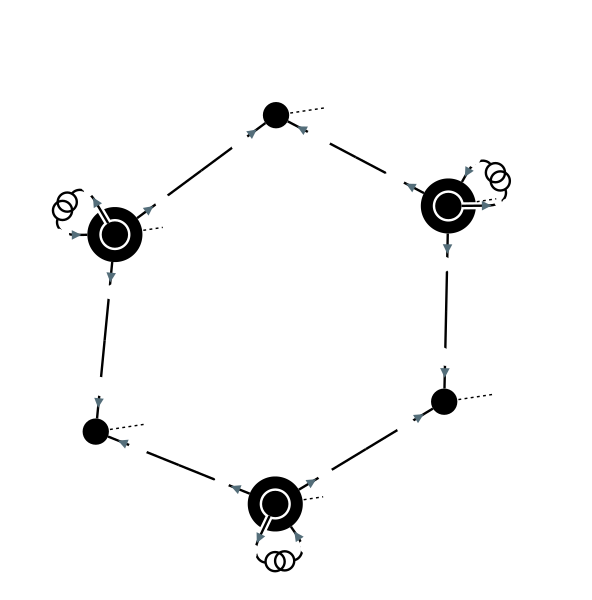

In [ ]:
#re-run power flow with updated values
#n2 = pp.network.create_ieee9()
results2=pp.loadflow.run_ac(n2)
pp.loadflow.run_ac(n2)
n2.get_network_area_diagram()

In [ ]:
# Print results one item at a time
voltages2=n2.get_buses().v_mag
print(f'Initial results: {voltages1}')
print(f'next results: {voltages2}')
lines_current2=n2.get_lines()[['i1','i2']]
print(f'Initial lines current: {lines_current1}')  
print(f'next lines current: {lines_current2}')  
#print(voltages.loc['VL1_0'])

Initial results: id
VL1_0    104.000000
VL1_1    102.578841
VL2_0    102.500000
VL2_1    102.576939
VL3_0    102.500000
VL3_1    103.235296
VL5_0     99.563088
VL6_0    101.265434
VL8_0    101.588260
Name: v_mag, dtype: float64
next results: id
VL1_0    108.000000
VL1_1    105.790062
VL2_0    102.500000
VL2_1    104.084651
VL3_0    102.500000
VL3_1    104.055779
VL5_0    105.514151
VL6_0    103.714001
VL8_0    102.841037
Name: v_mag, dtype: float64
Initial lines current:                 i1          i2
id                            
L7-8-0  429.924570  435.652249
L9-8-0  136.367931  194.469402
L7-5-0  489.814784  493.340101
L9-6-0  354.824370  347.591012
L5-4-0  325.539102  263.990934
L6-4-0  198.010881  172.908376
next lines current:                 i1          i2
id                            
L7-8-0  446.948902  456.128324
L9-8-0  111.305438  162.407571
L7-5-0  500.684425  446.017790
L9-6-0  393.915379  353.459446
L5-4-0  697.270735  667.751907
L6-4-0  210.004661  156.475317


In [ ]:
# Rather make a new variant to keep the initial variant
n2.clone_variant('InitialState', 'NewVariant')
n2.set_working_variant('NewVariant')

#First we can make a function to compare the two variants, and see what has changed.

def compare_variants(network, variant1, variant2, element_type='generators'): #Comparing two networks
    # Get data for first variant
    network.set_working_variant(variant1)
    if element_type == 'generators':
        df1 = network.get_generators()
    elif element_type == 'loads':
        df1 = network.get_loads()
    elif element_type == 'buses':
        df1 = network.get_buses()
    
    # Get data for second variant
    network.set_working_variant(variant2)
    if element_type == 'generators':
        df2 = network.get_generators()
    elif element_type == 'loads':
        df2 = network.get_loads()
    elif element_type == 'buses':
        df2 = network.get_buses()
    
    # Compare dataframes
    diff_mask = (df1 != df2).any(axis=1)
    differences = pd.concat([
        df1[diff_mask].add_suffix(f'_{variant1}'),
        df2[diff_mask].add_suffix(f'_{variant2}')
    ], axis=1)
    
    return differences



In [ ]:
# Modify generator parameters
n2.update_generators(
    id='B1-G', 
    target_p=75,  # New active power setpoint (MW)
    target_v=106,  # New voltage setpoint (pu)
    min_p=50,
    max_p=250
)

# Modify load parameters
n2.update_loads(
    id='B5-L',
    p0=250,  # Active power (MW)
    q0=40   # Reactive power (MVAr)
)
# Modify line parameters
n2.update_lines(
    id='L5-4-0',
    r=0.15,  # New resistance (pu)
    x=0.45   # New reactance (pu)
)

#Lets now compare the two variants, and see what has changed.
gen_diff=compare_variants(n2, 'InitialState', 'NewVariant', element_type='generators')
load_diff=compare_variants(n2, 'InitialState', 'NewVariant', element_type='loads')

In [ ]:
# run a new power flow simulation with singel slack bus instead of distributed slack bus
n2.set_working_variant('InitialState')
results3=lf.run_ac(n2, parameters=lf.Parameters(distributed_slack=False))
voltages3=n2.get_buses().v_mag
lines_current3=n2.get_lines()[['i1','i2']]
p3=n2.get_generators().p
#q3=n2.get_buses().q0

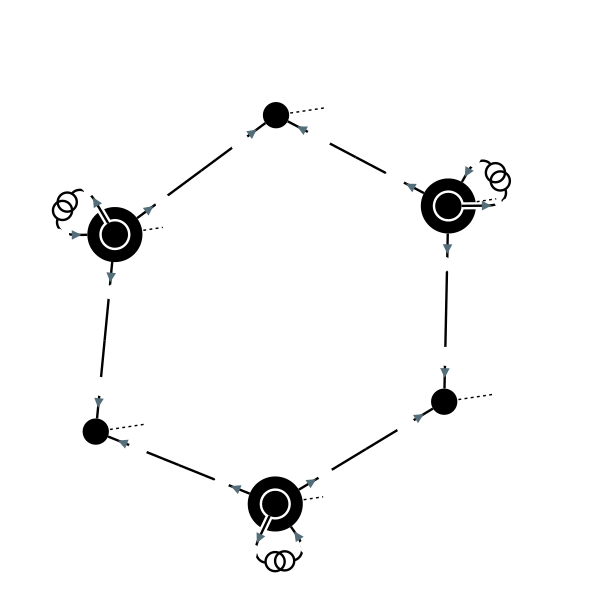

In [ ]:
n2.get_network_area_diagram(depth=1)

In [ ]:
print(f"Old: {voltages1}")
print(f"New: {voltages2}")
print(f"New2: {voltages3}")

print(f"Old: {lines_current1}")
print(f"New: {lines_current2}")
print(f"New2: {lines_current3}")


Old: id
VL1_0    104.000000
VL1_1    102.578841
VL2_0    102.500000
VL2_1    102.576939
VL3_0    102.500000
VL3_1    103.235296
VL5_0     99.563088
VL6_0    101.265434
VL8_0    101.588260
Name: v_mag, dtype: float64
New: id
VL1_0    108.000000
VL1_1    105.790062
VL2_0    102.500000
VL2_1    104.084651
VL3_0    102.500000
VL3_1    104.055779
VL5_0    105.514151
VL6_0    103.714001
VL8_0    102.841037
Name: v_mag, dtype: float64
New2: id
VL1_0    108.000000
VL1_1    105.799862
VL2_0    102.500000
VL2_1    104.077775
VL3_0    102.500000
VL3_1    104.055489
VL5_0    105.484211
VL6_0    103.719598
VL8_0    102.836597
Name: v_mag, dtype: float64
Old:                 i1          i2
id                            
L7-8-0  429.924570  435.652249
L9-8-0  136.367931  194.469402
L7-5-0  489.814784  493.340101
L9-6-0  354.824370  347.591012
L5-4-0  325.539102  263.990934
L6-4-0  198.010881  172.908376
New:                 i1          i2
id                            
L7-8-0  446.948902  456.128324


In [ ]:
# Now we control which bus is the slack bus (this is not correct, and set all other gens to PQ buses...)
def set_slack_bus(network, gen_id):
    # Get generators DataFrame and its index
    generators_df = network.get_generators()
    all_gens = generators_df.index.tolist()
    
    # Verify generator exists
    if gen_id not in all_gens:
        raise ValueError(f"Generator {gen_id} not found. Available generators: {all_gens}")
    
    # Set voltage regulation off for all generators
    network.update_generators(
        id=all_gens,
        voltage_regulator_on=[False] * len(all_gens)
    )
    
    # Set specified generator as slack
    network.update_generators(
        id=[gen_id],
        voltage_regulator_on=[True],
        target_v=[400.0],
        target_p=[100.0]
    )

In [ ]:
# Get current slack bus(es)
print("Before setting slack bus:")
print(n2.get_generators()[['name', 'voltage_regulator_on', 'bus_id']])
set_slack_bus(n2, 'B2-G')

print("\nAfter setting slack bus:")
print(n2.get_generators()[['name', 'voltage_regulator_on', 'bus_id']])



Before setting slack bus:
     name  voltage_regulator_on bus_id
id                                    
B1-G                       True  VL1_0
B2-G                       True  VL2_0
B3-G                       True  VL3_0

After setting slack bus:
     name  voltage_regulator_on bus_id
id                                    
B1-G                      False  VL1_0
B2-G                       True  VL2_0
B3-G                      False  VL3_0


In [ ]:
#Rerun the power flow with the new slack bus
results4=pp.loadflow.run_ac(n2)
voltages4=n2.get_buses().v_mag
lines_current4=n2.get_lines()[['i1','i2']]
p4=n2.get_generators().p
#q4=n2.get_buses().q0
n2.get_network_area_diagram(depth=1)
print(f"Old: {voltages1}")
print(f"New: {voltages2}")
print(f"New2: {voltages3}")
print(f"New3: {voltages4}")
print(f"Old: {lines_current1}")
print(f"New: {lines_current2}")
print(f"New2: {lines_current3}")
print(f"New3: {lines_current4}")    


Old: id
VL1_0    104.000000
VL1_1    102.578841
VL2_0    102.500000
VL2_1    102.576939
VL3_0    102.500000
VL3_1    103.235296
VL5_0     99.563088
VL6_0    101.265434
VL8_0    101.588260
Name: v_mag, dtype: float64
New: id
VL1_0    108.000000
VL1_1    105.790062
VL2_0    102.500000
VL2_1    104.084651
VL3_0    102.500000
VL3_1    104.055779
VL5_0    105.514151
VL6_0    103.714001
VL8_0    102.841037
Name: v_mag, dtype: float64
New2: id
VL1_0    108.000000
VL1_1    105.799862
VL2_0    102.500000
VL2_1    104.077775
VL3_0    102.500000
VL3_1    104.055489
VL5_0    105.484211
VL6_0    103.719598
VL8_0    102.836597
Name: v_mag, dtype: float64
New3: id
VL1_0    108.000000
VL1_1    105.799862
VL2_0    102.500000
VL2_1    104.077775
VL3_0    102.500000
VL3_1    104.055489
VL5_0    105.484211
VL6_0    103.719598
VL8_0    102.836597
Name: v_mag, dtype: float64
Old:                 i1          i2
id                            
L7-8-0  429.924570  435.652249
L9-8-0  136.367931  194.469402
L7-5-

#Adding more simulation steps
Here we add more steps in the simulation

In [ ]:
# Adding some load variations:
def create_ieee9_time_series(steps=5, p_set_gen2=163, p_set_gen3=85):
    # Create the IEEE 9-bus network
    network = pp.network.create_ieee9()
    
    # Define time steps
    snapshots = pd.date_range("2025-01-01 00:00", periods=steps, freq="h")
    
    # Define base loads and variation patterns
    base_loads = {
        'B5-L': {'p': 90, 'q': 30},
        'B6-L': {'p': 100, 'q': 35},
        'B8-L': {'p': 125, 'q': 50}
    }
    
    # Define oscillation patterns similar to PyPSA implementation
    base_patterns = {
        'B5-L': np.array([1, 1, 1, -1, -1]),
        'B6-L': np.array([0, 1, 1, -1, -1]),
        'B8-L': np.array([0, 0, 1, 0, -1])
    }
    
    variation = 0.1  # 30% variation
    
    # Store results for each time step
    results = {}
    load_values = {load_id: {'p': [], 'q': []} for load_id in base_loads.keys()}
    generator_values = {'B1-G': [], 'B2-G': [], 'B3-G': []}
    
    # Set generator values
    network.update_generators(id='B2-G', target_p=p_set_gen2)
    network.update_generators(id='B3-G', target_p=p_set_gen3)
    
    # Create and simulate each time step
    for step in range(min(steps, 5)):
        # Create a variant for this time step
        variant_id = f"step_{step}" # we have used the step_number as variant id
        network.clone_variant('InitialState',variant_id) # network is updated to include this variant...
        network.set_working_variant(variant_id) # here is where the equivalent to "snapshot" in pypsa is set, in powsybl it is called "working_variant"
        
        #with this working variant we can now make some changes to load, or to other grid characteristics
        # Update loads based on patterns
        for load_id, base_load in base_loads.items():
            pattern_value = base_patterns[load_id][step]
            p_value = base_load['p'] * (1 + variation * pattern_value)
            q_value = base_load['q'] * (1 + variation * pattern_value)
            
            network.update_loads(id=load_id, p0=p_value, q0=q_value)
            load_values[load_id]['p'].append(p_value)
            load_values[load_id]['q'].append(q_value)
        
        # Run load flow for this time step
        result = pp.loadflow.run_ac(network)
        results[step] = result
        
        # Get generator output for this time step
        generators = network.get_generators()
        for gen_id in ['B1-G', 'B2-G', 'B3-G']:
            #gen_data = generators[generators['id'] == gen_id]
            gen_data = generators[generators.index == gen_id]
            if not gen_data.empty:
                generator_values[gen_id].append(gen_data['p'].values[0])
        
        # Reset to base variant for next iteration
        network.set_working_variant("InitialState")
    
    return network, results, load_values, generator_values, snapshots



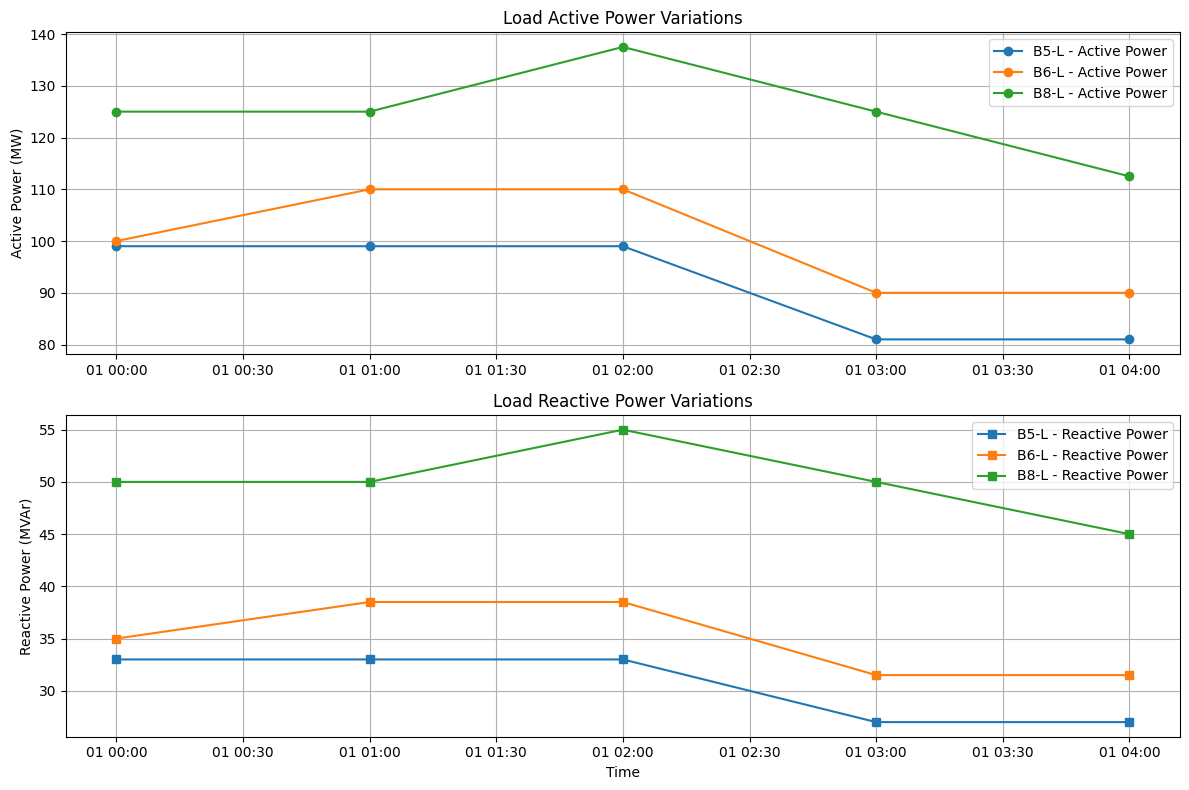

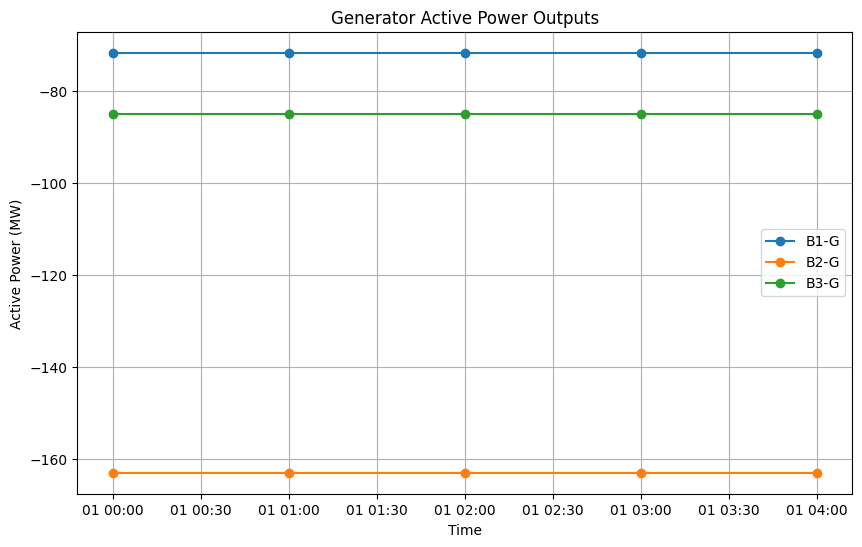

In [ ]:
# We can now use the procedure above to create time series simulation
network, results, load_values, generator_values, snapshots = create_ieee9_time_series()

# Plot load variations
plt.figure(figsize=(6, 4))
plt.subplot(2, 1, 1)
for load_id, values in load_values.items():
    plt.plot(snapshots, values['p'], marker='o', label=f"{load_id} - Active Power")
plt.title('Load Active Power Variations')
plt.ylabel('Active Power (MW)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for load_id, values in load_values.items():
    plt.plot(snapshots, values['q'], marker='s', label=f"{load_id} - Reactive Power")
plt.title('Load Reactive Power Variations')
plt.xlabel('Time')
plt.ylabel('Reactive Power (MVAr)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot generator outputs
plt.figure(figsize=(10, 6))
for gen_id, values in generator_values.items():
    plt.plot(snapshots, values, marker='o', label=gen_id)
plt.title('Generator Active Power Outputs')
plt.xlabel('Time')
plt.ylabel('Active Power (MW)')
plt.legend()
plt.grid(True)
plt.show()

## Plotting the results for timesteps as for PyPSA

In [ ]:
def create_ieee9_time_series_network(steps=5, p_set_gen2=163, p_set_gen3=85):
    """
    Create IEEE 9-bus network and prepare time series variants
    """
    # Create the IEEE 9-bus network
    network = pp.network.create_ieee9()
    
    # Define time steps
    snapshots = pd.date_range("2025-01-01 00:00", periods=steps, freq="h")
    
    # Define base loads and variation patterns
    base_loads = {
        'B5-L': {'p': 90, 'q': 30},
        'B6-L': {'p': 100, 'q': 35},
        'B8-L': {'p': 125, 'q': 50}
    }
    
    # Define oscillation patterns
    base_patterns = {
        'B5-L': np.array([1, 1, 1, -1, -1]),
        'B6-L': np.array([0, 1, 1, -1, -1]),
        'B8-L': np.array([0, 0, 1, 0, -1])
    }
    
    variation = 0.3  # 30% variation
    
    # Set generator values
    network.update_generators(id='B2-G', target_p=p_set_gen2)
    network.update_generators(id='B3-G', target_p=p_set_gen3)
    
    # Create variants for each time step
    for step in range(min(steps, 5)):
        variant_id = f"step_{step}"
        network.clone_variant("InitialState", variant_id)
        network.set_working_variant(variant_id)
        
        # Update loads based on patterns
        for load_id, base_load in base_loads.items():
            pattern_value = base_patterns[load_id][step]
            p_value = base_load['p'] * (1 + variation * pattern_value)
            q_value = base_load['q'] * (1 + variation * pattern_value)
            network.update_loads(id=load_id, p0=p_value, q0=q_value)
        
        network.set_working_variant("InitialState")
    
    return network, snapshots

def configure_slack_mode(network, mode='distributed', slack_bus_id=None):
    """
    Configure slack bus mode for load flow calculations
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    mode : str
        'distributed' - distribute slack across generators
        'single' - use single slack bus
    slack_bus_id : str, optional
        ID of bus to use as slack when mode='single'
        If None in single mode, uses most meshed bus
    
    Returns:
    --------
    pp.loadflow.Parameters
        Configured load flow parameters
    """
def configure_slack_mode(network, mode='distributed', slack_bus_id=None, balance_method='P_MAX'):
    """
    Configure slack bus mode for load flow calculations with specific power balancing
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    mode : str
        'distributed' - distribute slack across generators
        'single' - use single slack bus
    slack_bus_id : str, optional
        ID of bus to use as slack when mode='single'
    balance_method : str
        'P_MAX' - distribute proportional to generator max power
        'P' - distribute proportional to current generator power
        'MARGIN' - distribute proportional to remaining generator margin
        'LOAD' - distribute on loads
    """
    # Map balance methods to enum values
    balance_types = {
        'P_MAX': BalanceType.PROPORTIONAL_TO_GENERATION_P_MAX,
        'P': BalanceType.PROPORTIONAL_TO_GENERATION_P,
        'MARGIN': BalanceType.PROPORTIONAL_TO_GENERATION_REMAINING_MARGIN,
        'LOAD': BalanceType.PROPORTIONAL_TO_LOAD
    }
    
    # Base parameters with explicit distribution settings
    params = pp.loadflow.Parameters(
        voltage_init_mode=VoltageInitMode.UNIFORM_VALUES,
        transformer_voltage_control_on=True,
        use_reactive_limits=True,
        write_slack_bus=True,
        distributed_slack=True if mode.lower() == 'distributed' else False,
        balance_type=balance_types[balance_method],
        read_slack_bus=False  # Don't read existing slack bus configuration
    )
    
    # Add provider-specific parameters for better control
    if mode.lower() == 'distributed':
        params.provider_parameters = {
            'slackBusSelectionMode': 'MOST_MESHED',
            'balanceType': balance_method,
            'distributedSlack': 'true',
            'loadPowerFactorConstant': 'false',  # Allow power factor to vary
            'remainingPowerAdjustment': 'true',   # Enable power adjustment
            'computeMaximumMismatch': 'true'
        }
    elif mode.lower() == 'single':
        params.provider_parameters = {
            'slackBusSelectionMode': 'NAME' if slack_bus_id else 'MOST_MESHED',
            'slackBusesIds': slack_bus_id if slack_bus_id else '',
            'distributedSlack': 'false'
        }
    
    return params

def run_time_series_loadflow(network, snapshots, slack_mode='distributed', 
                           slack_bus_id=None, balance_method='P_MAX'):
    """
    Run load flow for time series with configurable slack handling
        
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    snapshots : pd.DatetimeIndex
        Time points for simulation
    slack_mode : str
        'distributed' or 'single'
    slack_bus_id : str, optional
        ID of slack bus if using single mode
    """
        # Initialize storage
    results = {}
    buses = network.get_buses()
    lines = network.get_lines()
    transformers = network.get_2_windings_transformers()
    
    # Initialize DataFrames
    bus_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            buses.index,
            ['P (MW)', 'Q (MVAr)', 'V (pu)', 'Angle (deg)']
        ])
    )
    
    line_results = pd.DataFrame(
        index=snapshots,
        columns=pd.MultiIndex.from_product([
            list(lines.index) + list(transformers.index),
            ['P0 (MW)', 'P1 (MW)', 'Q0 (MVAr)', 'Q1 (MVAr)', 'I1 (A)', 'I2 (A)']
        ])
    )
    
    # Add branch flow tracking
    slack_bus_results = pd.DataFrame(
        index=snapshots,
        columns=['bus_id', 'P_mismatch (MW)', 'distributed_P (MW)', 'P_branch_sum (MW)']
    )
    
    for step in range(len(snapshots)):
        print(f"\nProcessing timestep {step}")
        variant_id = f"step_{step}"
        network.set_working_variant(variant_id)
        
        # Store initial branch flows
        initial_lines = network.get_lines()
        
        # Run load flow
        lf_params = configure_slack_mode(network, slack_mode, slack_bus_id, balance_method)
        result = pp.loadflow.run_ac(network, parameters=lf_params)
        
        # Get updated branch flows
        updated_lines = network.get_lines()
        updated_transformers = network.get_2_windings_transformers()
        
        # Calculate net power flow at each bus through branches
        bus_branch_flows = {}
        for bus_id in buses.index:
            net_power = 0.0
            
            # Add line contributions
            for _, line in updated_lines.iterrows():
                if line['bus1_id'] == bus_id:
                    net_power += line['p1']  # Power leaving bus
                elif line['bus2_id'] == bus_id:
                    net_power += line['p2']  # Power entering bus
            
            # Add transformer contributions
            for _, trafo in updated_transformers.iterrows():
                if trafo['bus1_id'] == bus_id:
                    net_power += trafo['p1']
                elif trafo['bus2_id'] == bus_id:
                    net_power += trafo['p2']
            
            bus_branch_flows[bus_id] = net_power
        
        # Store component results
        if result[0].slack_bus_results:
            slack_info = result[0].slack_bus_results[0]
            slack_bus_id = slack_info.id
            
            # Calculate total branch power flow at slack bus
            slack_power_flow = bus_branch_flows.get(slack_bus_id, 0.0)
            
            slack_bus_results.loc[snapshots[step]] = {
                'bus_id': slack_bus_id,
                'P_mismatch (MW)': slack_info.active_power_mismatch,
                'distributed_P (MW)': result[0].distributed_active_power,
                'P_branch_sum (MW)': slack_power_flow
            }
            
            print(f"\nPower balance at step {step}:")
            print(f"Slack bus: {slack_bus_id}")
            print(f"Power mismatch: {slack_info.active_power_mismatch:.2f} MW")
            print(f"Branch power sum at slack: {slack_power_flow:.2f} MW")
            
            # Print branch flows connected to slack bus
            print("\nBranch flows connected to slack bus:")
            for _, line in updated_lines.iterrows():
                if slack_bus_id in [line['bus1_id'], line['bus2_id']]:
                    print(f"Line {line.name}: P1={line['p1']:.2f} MW, P2={line['p2']:.2f} MW")
        
        # Store component and slack results
        component_result = result[0]
        if component_result.slack_bus_results:
            slack_info = component_result.slack_bus_results[0]
            
            # Calculate total power adjustment across all generators
            generators = network.get_generators()
            total_p_adjustment = 0
            
            if slack_mode.lower() == 'distributed':
                # Sum up changes in generator outputs
                for _, gen in generators.iterrows():
                    if gen['voltage_regulator_on']:
                        total_p_adjustment += (gen['p'] - gen['target_p'])
            
            slack_bus_results.loc[snapshots[step]] = {
                'bus_id': slack_info.id,
                'P_mismatch (MW)': slack_info.active_power_mismatch,
                'distributed_P (MW)': component_result.distributed_active_power,
                'total_P_adjustment (MW)': total_p_adjustment
            }
            
            print(f"\nSnapshot {step} power balance:")
            print(f"Mismatch: {slack_info.active_power_mismatch:.2f} MW")
            print(f"Distributed: {component_result.distributed_active_power:.2f} MW")
            print(f"Total adjustment: {total_p_adjustment:.2f} MW")
        
        # Get updated network data for this variant
        updated_buses = network.get_buses()
        updated_lines = network.get_lines()
        updated_transformers = network.get_2_windings_transformers()
        generators = network.get_generators()
        loads = network.get_loads()
        voltage_levels = network.get_voltage_levels()
        
        # Store bus results
        for _, bus in updated_buses.iterrows():
            try:
                bus_id = bus.name
                voltage_level_id = bus['voltage_level_id']
                voltage_level = voltage_levels[voltage_levels.index == voltage_level_id].iloc[0]
                nominal_v = voltage_level['nominal_v']
                
                # Debug voltage values
                #print(f"\nBus {bus_id} voltage details:")
                #print(f"Voltage Level ID: {voltage_level_id}")
                #print(f"Nominal V: {nominal_v}")
                #print(f"V_mag: {bus['v_mag']}")
                #print(f"V_angle: {bus['v_angle']}")
                #print(f"V (pu): {bus['v_mag'] / nominal_v}")
                
                # Initialize power totals for this bus
                p_total = 0.0
                q_total = 0.0
                
                # Add generator injections
                bus_gens = generators[generators['bus_id'] == bus_id]
                for _, gen in bus_gens.iterrows():
                    # For generators, use actual values after load flow
                    p_total += gen['p']
                    q_total += gen['q']
                    print(f"Generator {gen.name} actual P={gen['p']}, Q={gen['q']}")
                
                # Subtract load consumption
                bus_loads = loads[loads['bus_id'] == bus_id]
                for _, load in bus_loads.iterrows():
                    p_total -= load['p0']
                    q_total -= load['q0']
                    print(f"Load {load.name} P=-{load['p0']}, Q=-{load['q0']}")
                
                # Store results for this timestep
                bus_results.loc[snapshots[step], (bus_id, 'P (MW)')] = p_total
                bus_results.loc[snapshots[step], (bus_id, 'Q (MVAr)')] = q_total
                bus_results.loc[snapshots[step], (bus_id, 'V (pu)')] = bus['v_mag'] / nominal_v
                bus_results.loc[snapshots[step], (bus_id, 'Angle (deg)')] = bus['v_angle']
                
            except Exception as e:
                print(f"Error processing bus {bus_id}: {str(e)}")
        
        # Store line results
        for _, line in updated_lines.iterrows():
            try:
                line_id = line.name
                line_results.loc[snapshots[step], (line_id, 'P0 (MW)')] = line['p1']
                line_results.loc[snapshots[step], (line_id, 'P1 (MW)')] = line['p2']
                line_results.loc[snapshots[step], (line_id, 'Q0 (MVAr)')] = line['q1']
                line_results.loc[snapshots[step], (line_id, 'Q1 (MVAr)')] = line['q2']
                line_results.loc[snapshots[step], (line_id, 'I1 (A)')] = line['i1']
                line_results.loc[snapshots[step], (line_id, 'I2 (A)')] = line['i2']
            except Exception as e:
                print(f"Error processing line {line_id}: {str(e)}")
        
        # Reset to base variant
        network.set_working_variant("InitialState")
    
    return results, bus_results, line_results, slack_bus_results

In [25]:
def plot_network_results(network, results_df, slack_results):
    """
    Plot network results in 4 subplots: P, Q, V_mag, and V_ang with bus types in legend
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    results_df : pd.DataFrame
        DataFrame containing bus results
    slack_results : pd.DataFrame
        DataFrame containing slack bus results
    """
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    
    # Get data for each bus
    buses = network.get_buses()
    loads = network.get_loads()
    generators = network.get_generators()
    
    # Get slack bus ID from results
    slack_bus_id = slack_results['bus_id'].iloc[0]
    
    for bus_id in buses.index:
        # Determine bus type for legend
        if bus_id in loads['bus_id'].values:
            bus_type = f"{bus_id} (Load)"
        elif bus_id in generators['bus_id'].values:
            gen = generators[generators['bus_id'] == bus_id]
            if bus_id == slack_bus_id:
                bus_type = f"{bus_id} (Gen-Slack)"
                # Add distributed power to slack bus P
                results_df.loc[:, (bus_id, 'P (MW)')] += slack_results['distributed_P (MW)']
            else:
                if gen['voltage_regulator_on'].iloc[0]:
                    bus_type = f"{bus_id} (Gen-PV)"
                else:
                    bus_type = f"{bus_id} (Gen-PQ)"
        else:
            bus_type = bus_id
            
        # Active Power (P)
        ax1.plot(results_df.index, results_df[bus_id]['P (MW)'], marker='o', label=bus_type)
        ax1.set_ylabel('P (MW)')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True)
        
        # Reactive Power (Q)
        ax2.plot(results_df.index, results_df[bus_id]['Q (MVAr)'], marker='o', label=bus_type)
        ax2.set_ylabel('Q (MVAr)')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True)
        
        # Voltage Magnitude
        ax3.plot(results_df.index, results_df[bus_id]['V (pu)'], marker='o', label=bus_type)
        ax3.set_ylabel('Voltage (p.u.)')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True)
        
        # Voltage Angle
        ax4.plot(results_df.index, results_df[bus_id]['Angle (deg)'], marker='o', label=bus_type)
        ax4.set_ylabel('Angle (degrees)')
        ax4.set_xlabel('Time')
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax4.grid(True)

    # Add titles with additional information
    ax1.set_title('Active Power at Buses\n' + 
                 f'Slack Bus Power Mismatch: {slack_results["P_mismatch (MW)"].iloc[-1]:.2f} MW')
    
    plt.tight_layout()
    plt.show()

def plot_line_results(network, results_df):
    """
    Plot line flow results with P, Q for all branches and currents with limits for lines
    """
    # Get all branches and current limits
    lines = network.get_lines()
    transformers = network.get_2_windings_transformers()
    all_branches = list(lines.index) + list(transformers.index)
    
    # Get current limits DataFrame
    current_limits_df = network.get_current_limits()
    
    for i, branch_id in enumerate(all_branches):
        # Determine if branch is a line or transformer
        is_line = branch_id in lines.index
        
        # Create figure with appropriate number of subplots
        n_plots = 3 if is_line else 2
        fig, axs = plt.subplots(1, n_plots, figsize=(6*n_plots, 4))
        
        # Get branch details and limits
        if is_line:
            branch = lines.loc[branch_id]
            try:
                # Get current limit from DataFrame using MultiIndex
                current_limit = current_limits_df.loc[(branch_id, 'permanent_limit'), 'value']
            except Exception as e:
                print(f"Could not get current limit for {branch_id}: {str(e)}")
                current_limit = None
        else:
            branch = transformers.loc[branch_id]
            current_limit = None
            
        from_bus = branch['bus1_id']
        to_bus = branch['bus2_id']
        branch_name = f"{branch_id} ({from_bus}->{to_bus})"
        
        # Active Power (P) plot
        p0_series = results_df.loc[:, (branch_id, 'P0 (MW)')]
        p1_series = results_df.loc[:, (branch_id, 'P1 (MW)')]
        axs[0].plot(results_df.index, p0_series, marker='o',
                   label=f"P-in (from {from_bus})")
        axs[0].plot(results_df.index, -p1_series, marker='s',
                   label=f"P-out (to {to_bus})")
        axs[0].set_ylabel('P (MW)')
        axs[0].set_title(f"Active Power Flow - {branch_name}")
        axs[0].legend()
        axs[0].grid(True)
        
        # Reactive Power (Q) plot
        q0_series = results_df.loc[:, (branch_id, 'Q0 (MVAr)')]
        q1_series = results_df.loc[:, (branch_id, 'Q1 (MVAr)')]
        axs[1].plot(results_df.index, q0_series, marker='o',
                   label=f"Q-in (from {from_bus})")
        axs[1].plot(results_df.index, -q1_series, marker='s',
                   label=f"Q-out (to {to_bus})")
        axs[1].set_ylabel('Q (MVAr)')
        axs[1].set_title(f"Reactive Power Flow - {branch_name}")
        axs[1].legend()
        axs[1].grid(True)
        
        # Current (I) plot - only for lines
        if is_line:
            i1_series = results_df.loc[:, (branch_id, 'I1 (A)')]
            i2_series = results_df.loc[:, (branch_id, 'I2 (A)')]
            
            axs[2].plot(results_df.index, i1_series, marker='o',
                       label=f"I-in (from {from_bus})")
            axs[2].plot(results_df.index, i2_series, marker='s',
                       label=f"I-out (to {to_bus})")
            
            # Plot current limit if available
            if current_limit is not None:
                axs[2].axhline(y=current_limit, color='r', linestyle='--',
                             label=f"Current Limit ({current_limit:.0f} A)")
                max_loading = max(max(i1_series), max(i2_series)) / current_limit * 100
                axs[2].text(0.02, 0.98, f'Max Loading: {max_loading:.1f}%',
                          transform=axs[2].transAxes, verticalalignment='top')
            
            axs[2].set_ylabel('Current (A)')
            axs[2].set_title(f"Current Flow - {branch_name}")
            axs[2].legend()
            axs[2].grid(True)
        
        plt.tight_layout()
        plt.show()

In [6]:
def set_slack_bus_with_verification(network,slack_bus):
    # Get current slack bus(es)
    print("Before setting slack bus:")
    print(network.get_generators()[['name', 'voltage_regulator_on', 'bus_id']])
    set_slack_bus(network, slack_bus)

    print("\nAfter setting slack bus:")
    print(network.get_generators()[['name', 'voltage_regulator_on', 'bus_id']])
    return network

In [24]:
def set_line_current_limits(network, line_limits):
    """
    Set permanent current limits for lines using create_operational_limits
    
    Parameters:
    -----------
    network : Network
        pypowsybl network object
    line_limits : dict
        Dictionary of line limits in format {line_id: current_limit_value}
        Example: {'L7-8': 500, 'L9-8': 400}
    
    Returns:
    --------
    Network
        Updated network with operational limits
    """
    # Prepare the arguments for create_operational_limits
    element_ids = list(line_limits.keys())
    values = list(line_limits.values())
    n_lines = len(element_ids)
    
    # Create operational limits with permanent current limits
    network.create_operational_limits(
        element_id=element_ids,
        side=['ONE'] * n_lines,  # 'ONE' for each line
        name=['PERMANENT'] * n_lines,
        type=['CURRENT'] * n_lines,
        value=values,
        acceptable_duration=[-1] * n_lines,  # -1 indicates permanent limit
        fictitious=[False] * n_lines
    )
    
    return network


Processing timestep 0

Power balance at step 0:
Slack bus: VL1_1
Power mismatch: 26.47 MW
Branch power sum at slack: 26.47 MW

Branch flows connected to slack bus:
Line L5-4-0: P1=-47.68 MW, P2=47.95 MW
Line L6-4-0: P1=-49.72 MW, P2=50.15 MW

Snapshot 0 power balance:
Mismatch: 26.47 MW
Distributed: 0.00 MW
Total adjustment: 0.00 MW
Generator B1-G actual P=-71.64102, Q=-22.384881420511448
Generator B2-G actual P=-163.0, Q=-11.7823266124424
Generator B3-G actual P=-85.0, Q=3.101169628083742
Load B5-L P=-117.0, Q=-39.0
Load B6-L P=-100.0, Q=-35.0
Load B8-L P=-125.0, Q=-50.0

Processing timestep 1

Power balance at step 1:
Slack bus: VL1_1
Power mismatch: 57.17 MW
Branch power sum at slack: 57.17 MW

Branch flows connected to slack bus:
Line L5-4-0: P1=-51.72 MW, P2=52.03 MW
Line L6-4-0: P1=-75.74 MW, P2=76.78 MW

Snapshot 1 power balance:
Mismatch: 57.17 MW
Distributed: 0.00 MW
Total adjustment: 0.00 MW
Generator B1-G actual P=-71.64102, Q=-29.90012654888253
Generator B2-G actual P=-163

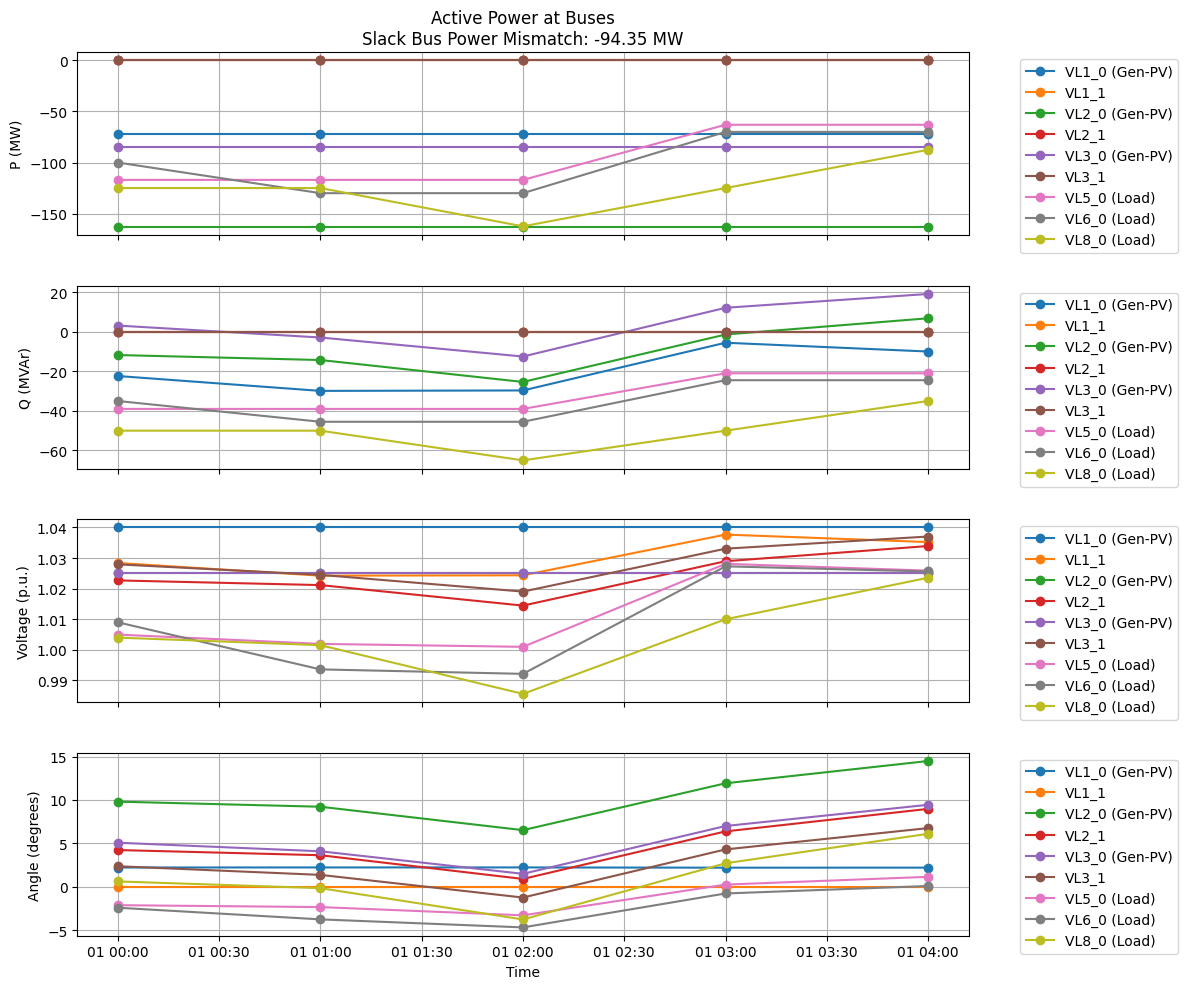

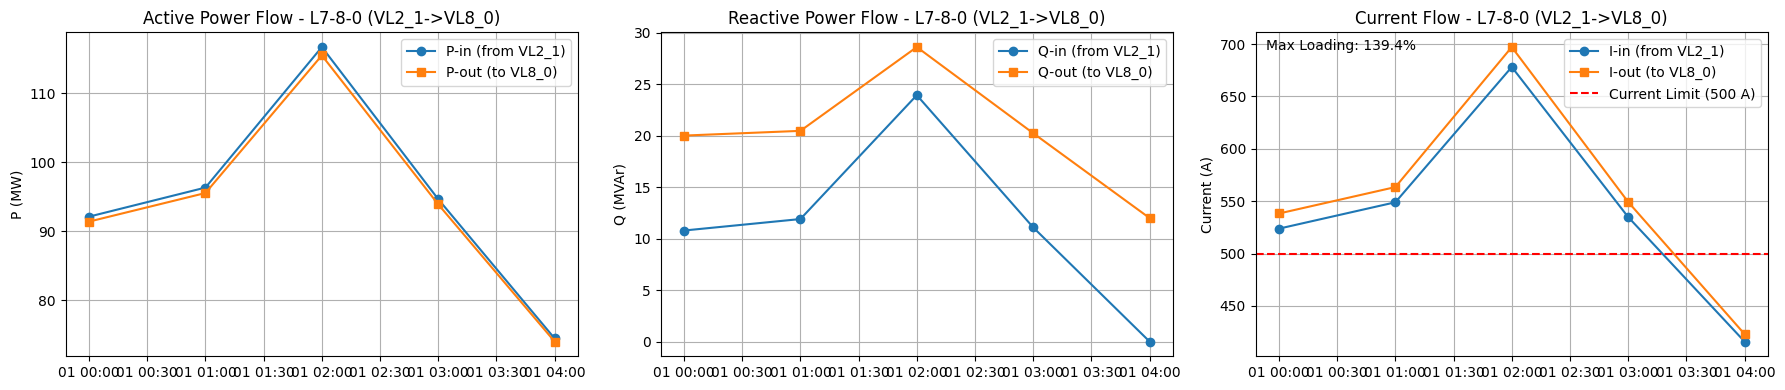

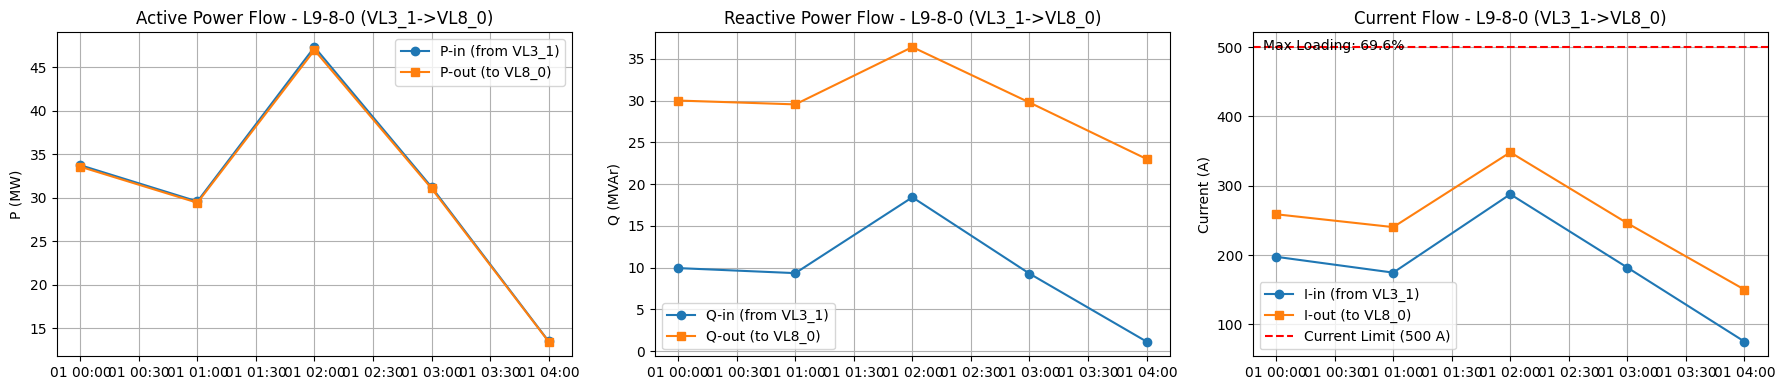

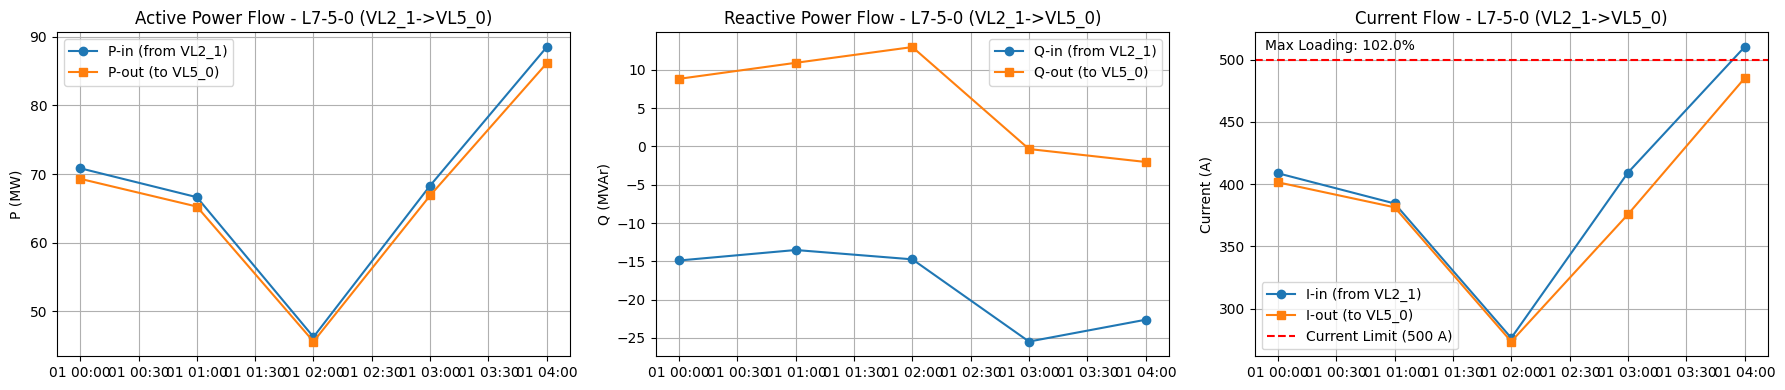

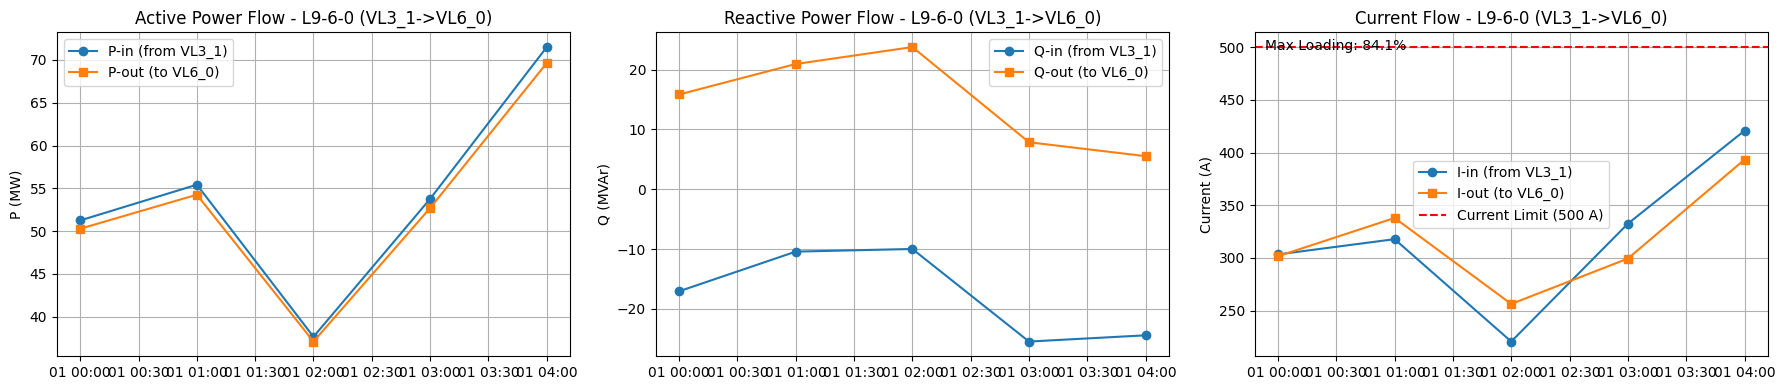

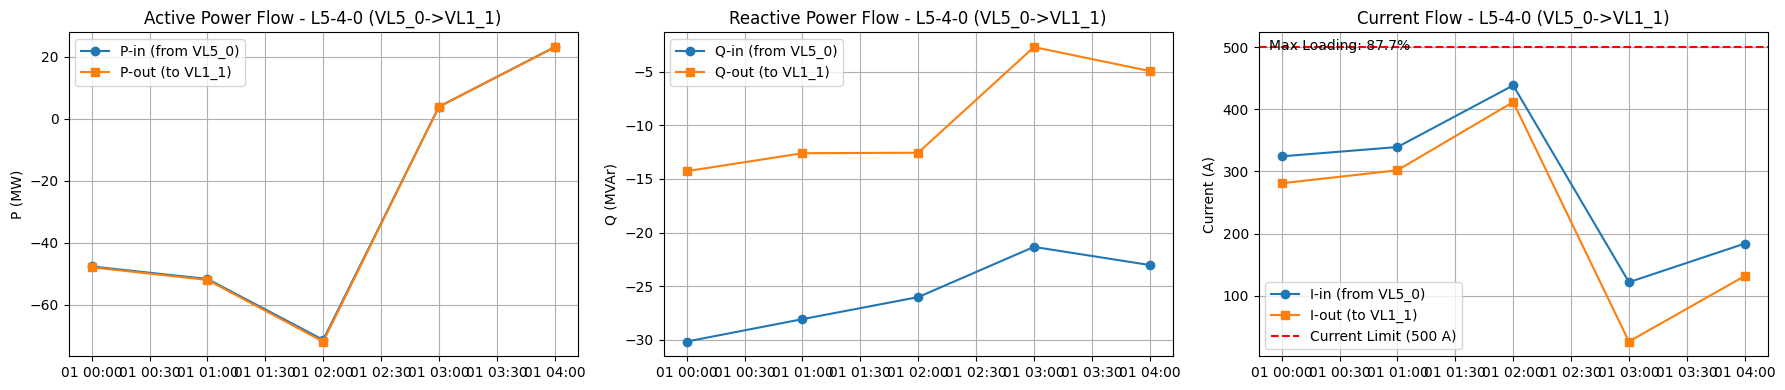

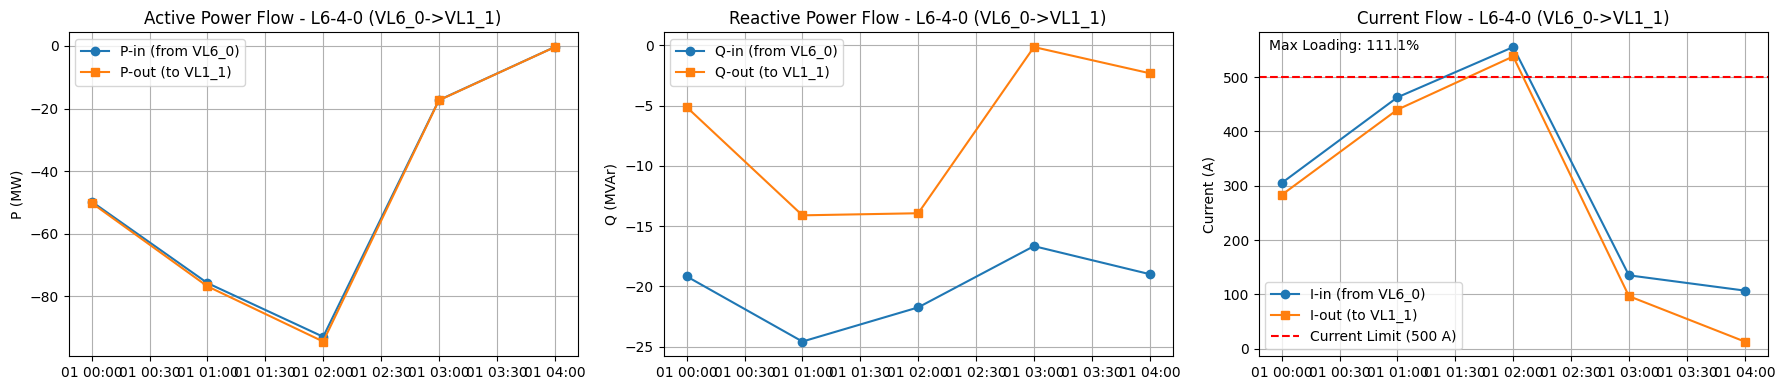

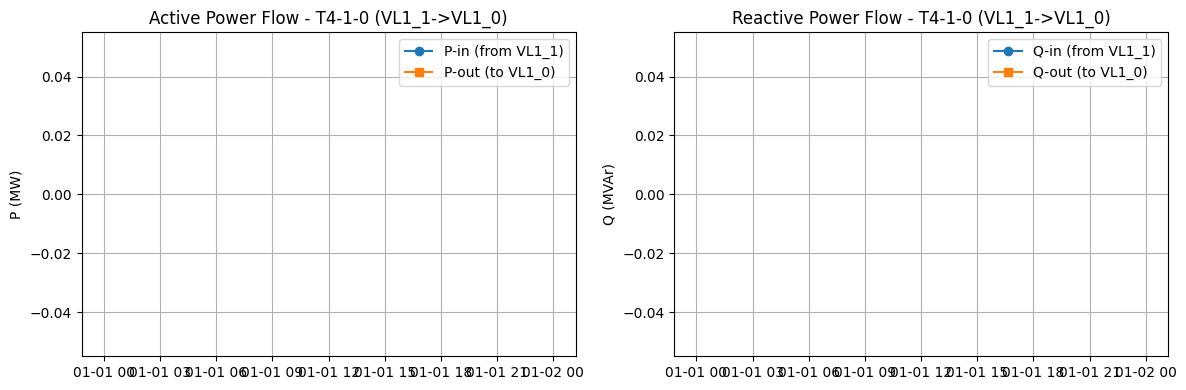

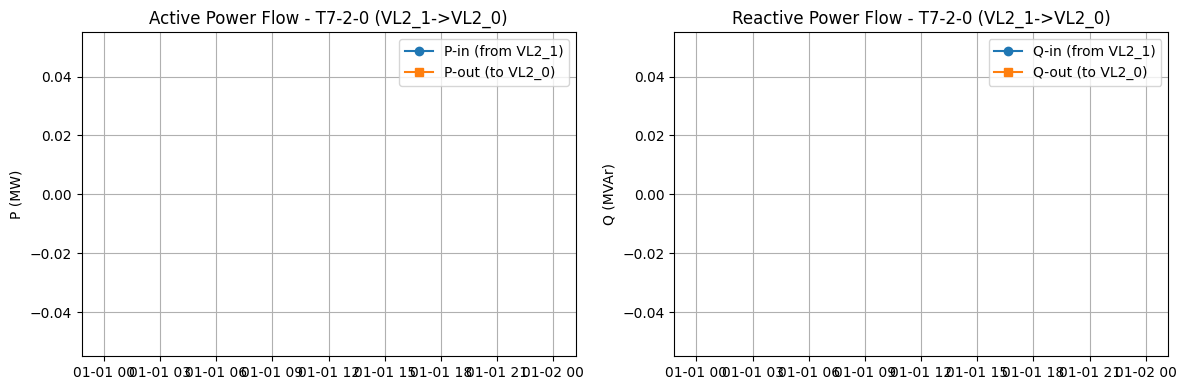

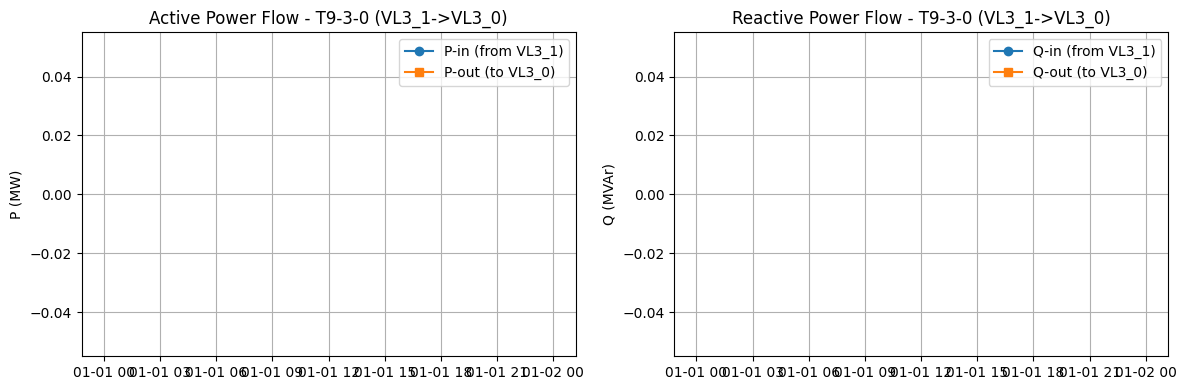

In [78]:
# Test that everything is working as planned
n_test, snapshots_test = create_ieee9_time_series_network(p_set_gen2=163, p_set_gen3=85)
#Setting the limits
line_limits = {
    'L7-8-0': 500,  # 500 A permanent limit
    'L9-8-0': 500,
    'L7-5-0': 500,
    'L9-6-0': 500,
    'L5-4-0': 500,
    'L6-4-0': 500
}
n_test = set_line_current_limits(n_test, line_limits)
#run the power flow simulation with singel slack-bus selected
results_test, bus_results_test, line_results_test, slack_results_test = run_time_series_loadflow(n_test, snapshots_test,slack_mode='single', slack_bus_id='B1-G',balance_method='P_MAX')
#results_test, bus_results_test, line_results_test, slack_results_test = run_time_series_loadflow(n_test, snapshots_test)
# Plot network results
plot_network_results(n_test, bus_results_test,slack_results_test)
# Plot line results
plot_line_results(n_test, line_results_test)

In [79]:
# Plot network area diagrams for each variant/timestep
n_test.set_working_variant('step_0')
results_test=pp.loadflow.run_ac(n_test, parameters=lf.Parameters(distributed_slack=False))

In [82]:
print(results_test[0].distributed_active_power)

0.0


In [ ]:
#No longer needed, included in the standard plot function
def plot_line_currents_with_limits(network, line_results):
    """Plot line currents compared to thermal limits"""
    import matplotlib.pyplot as plt
    
    lines_df = network.get_lines()
    time_points = range(len(line_results))
    
    # Subplot for each line
    n_lines = len(lines_df)
    fig, axes = plt.subplots(n_lines, 1, figsize=(12, 4*n_lines))
    
    for idx, (line_id, line_data) in enumerate(line_results.items()):
        ax = axes[idx] if n_lines > 1 else axes
        
        # Current values
        ax.plot(time_points, line_data['i1'], label='Current (A)', color='blue')
        
        # Add thermal limit
        thermal_limit = lines_df.loc[line_id, 'current_limits1']
        if not pd.isna(thermal_limit):
            ax.axhline(y=thermal_limit, color='red', linestyle='--', 
                      label=f'Thermal Limit ({thermal_limit:.0f} A)')
        
        ax.set_title(f'Line {line_id} Loading')
        ax.set_xlabel('Time Point')
        ax.set_ylabel('Current (A)')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

,,side,value,acceptable_duration
branch_id,name,,,
L7-8-0,permanent_limit,ONE,300.0,-1
L9-8-0,permanent_limit,ONE,200.0,-1
L7-5-0,permanent_limit,ONE,350.0,-1
L9-6-0,permanent_limit,ONE,200.0,-1
L5-4-0,permanent_limit,ONE,400.0,-1
L6-4-0,permanent_limit,ONE,350.0,-1


In [ ]:
n2.get_lines(attributes=["selected_limits_group_1", "selected_limits_group_2"])

In [ ]:
#create a new version of the network with operational limits
n_thermal_limits, results_thermal_limits, bus_results_thermal_limits, line_results_thermal_limits, snapshots_thermal_limits = create_ieee9_time_series_complete()
default_limits=n_thermal_limits.get_operational_limits()
n_thermal_limits.get_lines()

In [ ]:
# Create and set limits

#Setting the limits
line_limits = {
    'L7-8-0': 500,  # 500 A permanent limit
    'L9-8-0': 400,
    'L7-5-0': 450,
    'L9-6-0': 400,
    'L5-4-0': 500,
    'L6-4-0': 450
}


#setting the limits
n_thermal_limits = set_line_current_limits(n_thermal_limits, line_limits)

In [ ]:
#check thermal limits in the network

new_Limits=n_thermal_limits.get_operational_limits()
print(default_limits)
print(new_Limits)

Empty DataFrame
Columns: [element_type, side, name, type, value, acceptable_duration]
Index: []
           element_type side             name     type  value  \
element_id                                                      
L7-8-0             LINE  ONE  permanent_limit  CURRENT  500.0   
L9-8-0             LINE  ONE  permanent_limit  CURRENT  400.0   
L7-5-0             LINE  ONE  permanent_limit  CURRENT  450.0   
L9-6-0             LINE  ONE  permanent_limit  CURRENT  400.0   
L5-4-0             LINE  ONE  permanent_limit  CURRENT  500.0   
L6-4-0             LINE  ONE  permanent_limit  CURRENT  450.0   

            acceptable_duration  
element_id                       
L7-8-0                       -1  
L9-8-0                       -1  
L7-5-0                       -1  
L9-6-0                       -1  
L5-4-0                       -1  
L6-4-0                       -1  


In [ ]:
n_thermal_limits.get_lines(attributes=["selected_limits_group_1", "selected_limits_group_2"])

,selected_limits_group_1,selected_limits_group_2
id,,
L7-8-0,DEFAULT,DEFAULT
L9-8-0,DEFAULT,DEFAULT
L7-5-0,DEFAULT,DEFAULT
L9-6-0,DEFAULT,DEFAULT
L5-4-0,DEFAULT,DEFAULT
L6-4-0,DEFAULT,DEFAULT


In [ ]:
# Plot network results
plot_network_results(n_thermal_limits, bus_results_thermal_limits)

# Plot line results with thermal limits
plot_line_currents_with_limits(n_thermal_limits, line_results_thermal_limits)